In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_absolute_error


In [2]:
df=pd.read_csv('/content/drive/My Drive/Bike-demand/master_final.csv')

In [3]:
df['bikes']=df['bikes'].astype('float16')


df['pressure']=df['pressure'].astype('float16')
df['temperature']=df['temperature'].astype('float16')
df['wind']=df['wind'].astype('float16')
df['altitude']=df['altitude'].astype('float16')

df['lag_beau_temps']=df['lag_beau_temps'].astype('float16')
df['lag_nuageux']=df['lag_nuageux'].astype('float16')
df['lag_pluvieux']=df['lag_pluvieux'].astype('float16')
df['lag_orage']=df['lag_orage'].astype('float16')
df['lag_30m']=df['lag_30m'].astype('float16')
df['lag_7j']=df['lag_7j'].astype('float16')


df['station']=df['station'].astype('int16')
df['clouds']=df['clouds'].astype('int16')
df['humidity']=df['humidity'].astype('int16')
df['pressure']=df['pressure'].astype('int16')


df['beau_temps']=df['beau_temps'].astype('int8')
df['nuageux']=df['nuageux'].astype('int8')
df['pluvieux']=df['pluvieux'].astype('int8')
df['pluie']=df['pluie'].astype('int8')
df['orage']=df['orage'].astype('int8')


df['hour']=df['hour'].astype('int8')
df['day']=df['day'].astype('int8')
df['month']=df['month'].astype('int8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10340547 entries, 0 to 10340546
Data columns (total 25 columns):
 #   Column          Dtype  
---  ------          -----  
 0   datetime        object 
 1   bikes           float16
 2   station         int16  
 3   clouds          int16  
 4   humidity        int16  
 5   pressure        int16  
 6   temperature     float16
 7   wind            float16
 8   altitude        float16
 9   beau_temps      int8   
 10  nuageux         int8   
 11  pluvieux        int8   
 12  pluie           int8   
 13  orage           int8   
 14  lag_beau_temps  float16
 15  lag_nuageux     float16
 16  lag_pluvieux    float16
 17  lag_pluie       float64
 18  lag_orage       float16
 19  hour            int8   
 20  day             int8   
 21  month           int8   
 22  weekday         int64  
 23  lag_30m         float16
 24  lag_7j          float16
dtypes: float16(10), float64(1), int16(4), int64(1), int8(8), object(1)
memory usage: 591.7+ MB


In [ ]:
df.station.value_counts()


105     8997
1151    8996
422     8996
460     8996
459     8996
        ... 
455     7064
620     7035
343     5617
742     3793
0       3107
Name: station, Length: 1152, dtype: int64

In [4]:
features=['station',
          
          
          
          
          'clouds',
          'humidity',
          'pressure',
          'temperature',
          'wind',

          'altitude',




          'hour',
          'day',
          'month',
          'weekday',


          'beau_temps',
          'beau_temps',
          'pluvieux',
          'pluie',
          'orage',

          'lag_beau_temps',
          'lag_beau_temps',
          'lag_pluvieux',
          'lag_pluie',
          'lag_orage',            


          #'lag_30m',
          'lag_7j',
          


          ]

In [5]:
def train_test_split(df):
     

    x_train = df[df['datetime']  <= '2016-09-27']
    y_train = x_train['bikes']
    x_val = df[(df['datetime'] > '2016-09-27') & (df['datetime'] <= '2016-10-05')]
    y_val = x_val['bikes']
    test = df[(df['datetime'] > '2016-10-05')]

    return x_train, y_train, x_val, y_val, test
x_train, y_train, x_val, y_val, test= train_test_split(df)

print(len(x_train))
print(len(x_val))
print(len(test))


9877766
441499
21282


In [7]:
def run_lgb(x_train, y_train, x_val, y_val,test):
    



    params={'learning_rate': 0.003,
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'metric': 'mae',
        'sub_feature': 0.5,
        'num_leaves': 262,
        'min_data': 64,
        'num_iterations' : 2500,
        'max_depth': 8
        }

    evals_result = {}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    catFeats = ["hour","weekday","month","day","station"]  
    
    
    model = lgb.train(params, train_set, categorical_feature = catFeats,early_stopping_rounds = 300, valid_sets = [train_set, val_set], verbose_eval = 10,\
                       evals_result=evals_result)
    
    ax = lgb.plot_metric(evals_result)
    plt.show()

    lgb.plot_importance(model, importance_type="gain", precision=0, figsize=(6, 13));
    lgb.plot_importance(model, importance_type="split", precision=0, figsize=(6, 13));

    val_pred = model.predict(x_val[features], num_iteration=model.best_iteration)
    val_score = np.sqrt(mean_absolute_error(val_pred, y_val))
    print(f'Our val mae score is {val_score}')

    y_pred = model.predict(test[features], num_iteration=model.best_iteration)
    test['value'] = y_pred

    return test, model

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'hour', 'month', 'station', 'weekday']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[10]	training's l1: 11.0531	valid_1's l1: 11.2748
[20]	training's l1: 10.9328	valid_1's l1: 11.1391
[30]	training's l1: 10.8054	valid_1's l1: 11.0037
[40]	training's l1: 10.6742	valid_1's l1: 10.8499
[50]	training's l1: 10.5757	valid_1's l1: 10.7385
[60]	training's l1: 10.4766	valid_1's l1: 10.6224
[70]	training's l1: 10.4014	valid_1's l1: 10.5402
[80]	training's l1: 10.2998	valid_1's l1: 10.4284
[90]	training's l1: 10.2055	valid_1's l1: 10.3224
[100]	training's l1: 10.0995	valid_1's l1: 10.2003
[110]	training's l1: 10.0138	valid_1's l1: 10.1022
[120]	training's l1: 9.92552	valid_1's l1: 9.9945
[130]	training's l1: 9.83774	valid_1's l1: 9.89529
[140]	training's l1: 9.7384	valid_1's l1: 9.78287
[150]	training's l1: 9.65614	valid_1's l1: 9.68806
[160]	training's l1: 9.59249	valid_1's l1: 9.62461
[170]	training's l1: 9.49093	valid_1's l1: 9.51154
[180]	training's l1: 9.41166	valid_1's l1: 9.42492
[190]	training's l1: 9.36089	v

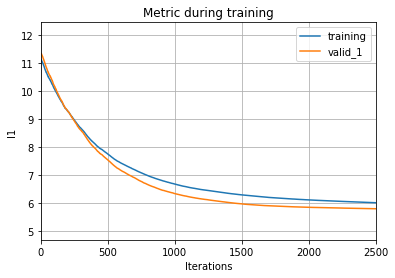

Our val mae score is 2.4346176669016106


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 2h 31min 9s, sys: 13.3 s, total: 2h 31min 22s
Wall time: 1h 17min 37s


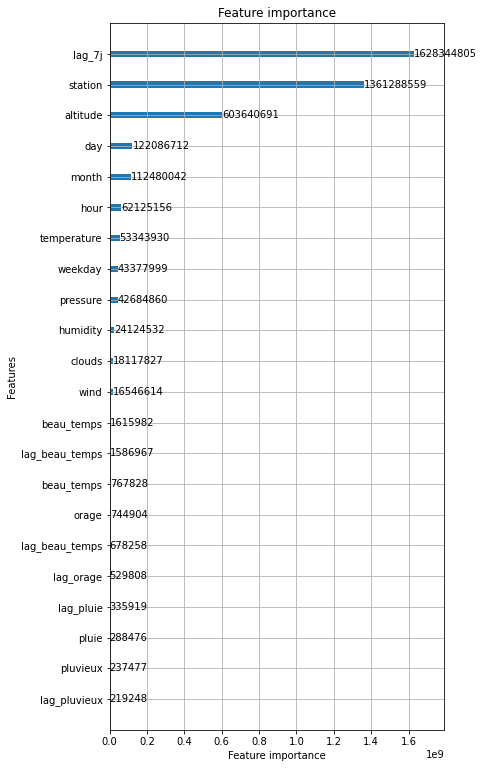

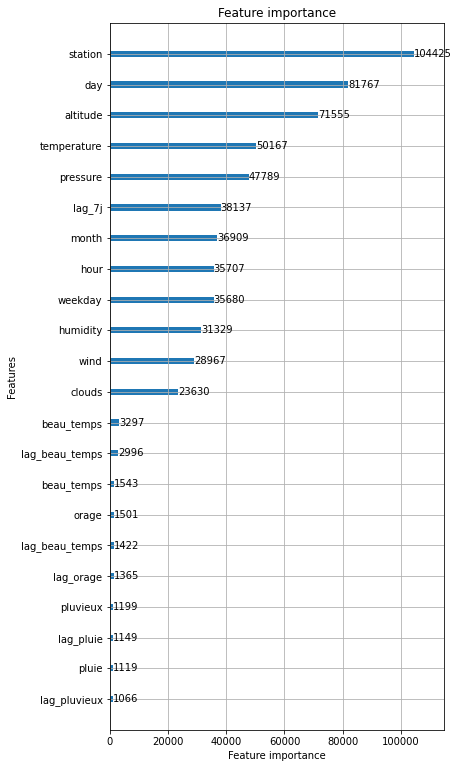

In [8]:
%%time
import lightgbm as lgb


y_pred, model= run_lgb(x_train, y_train, x_val, y_val,test)

In [9]:
test=test.set_index('datetime')

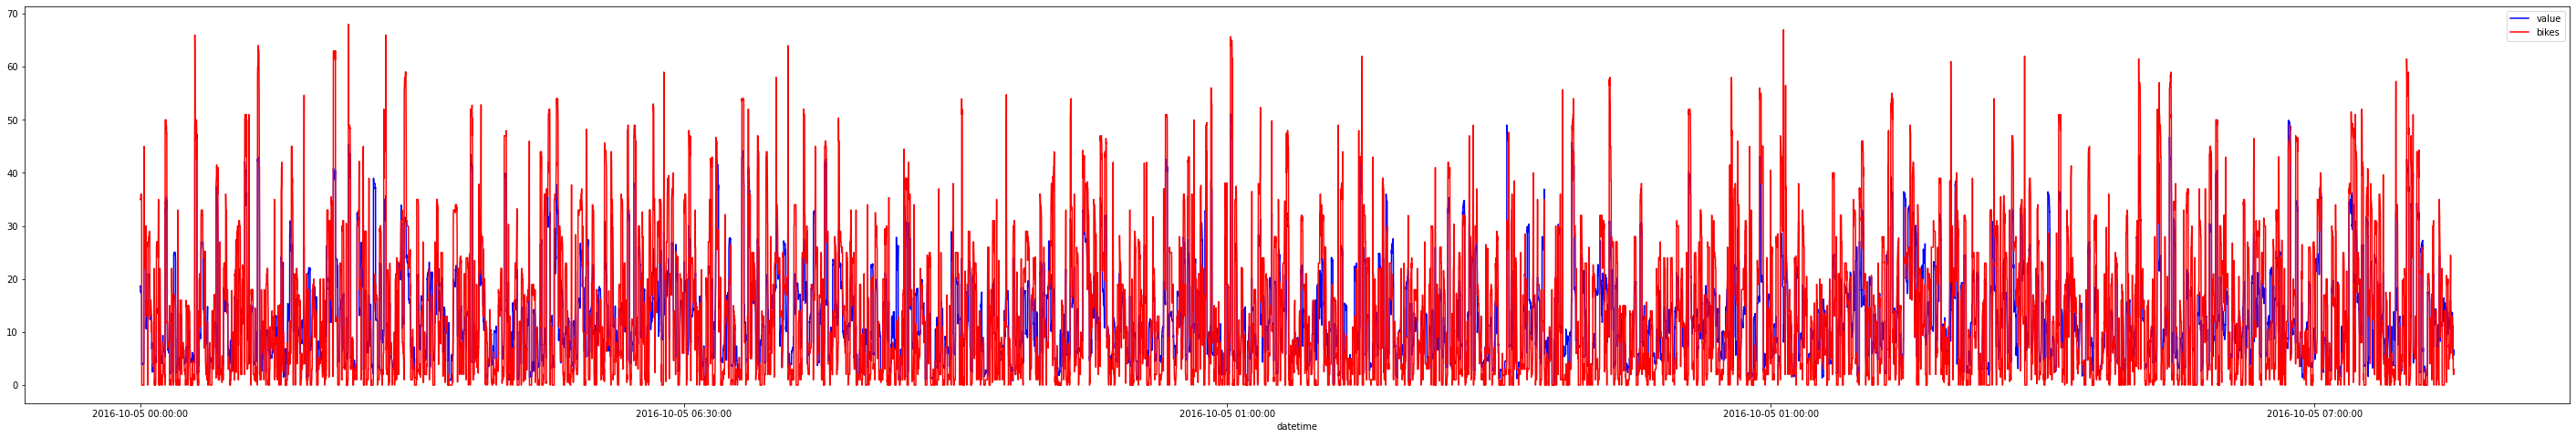

In [10]:


ax = test['value'].plot(figsize=(50,8), legend=True, color='blue')
test['bikes'].plot(legend=True, color='red', figsize=(50,8))

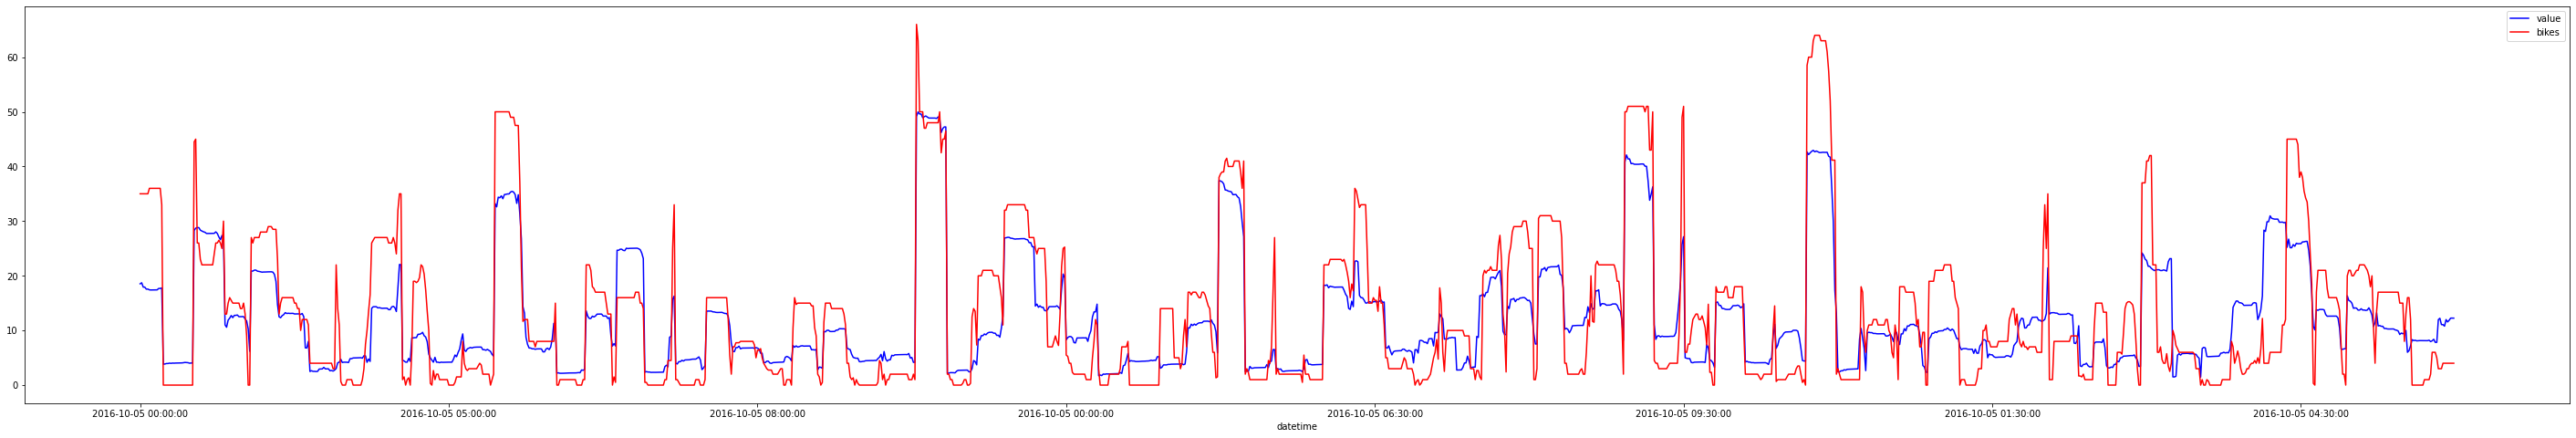

In [11]:
ax = test['value'][:1500].plot(figsize=(50,8), legend=True, color='blue')
test['bikes'][:1500].plot(legend=True, color='red', figsize=(50,8))

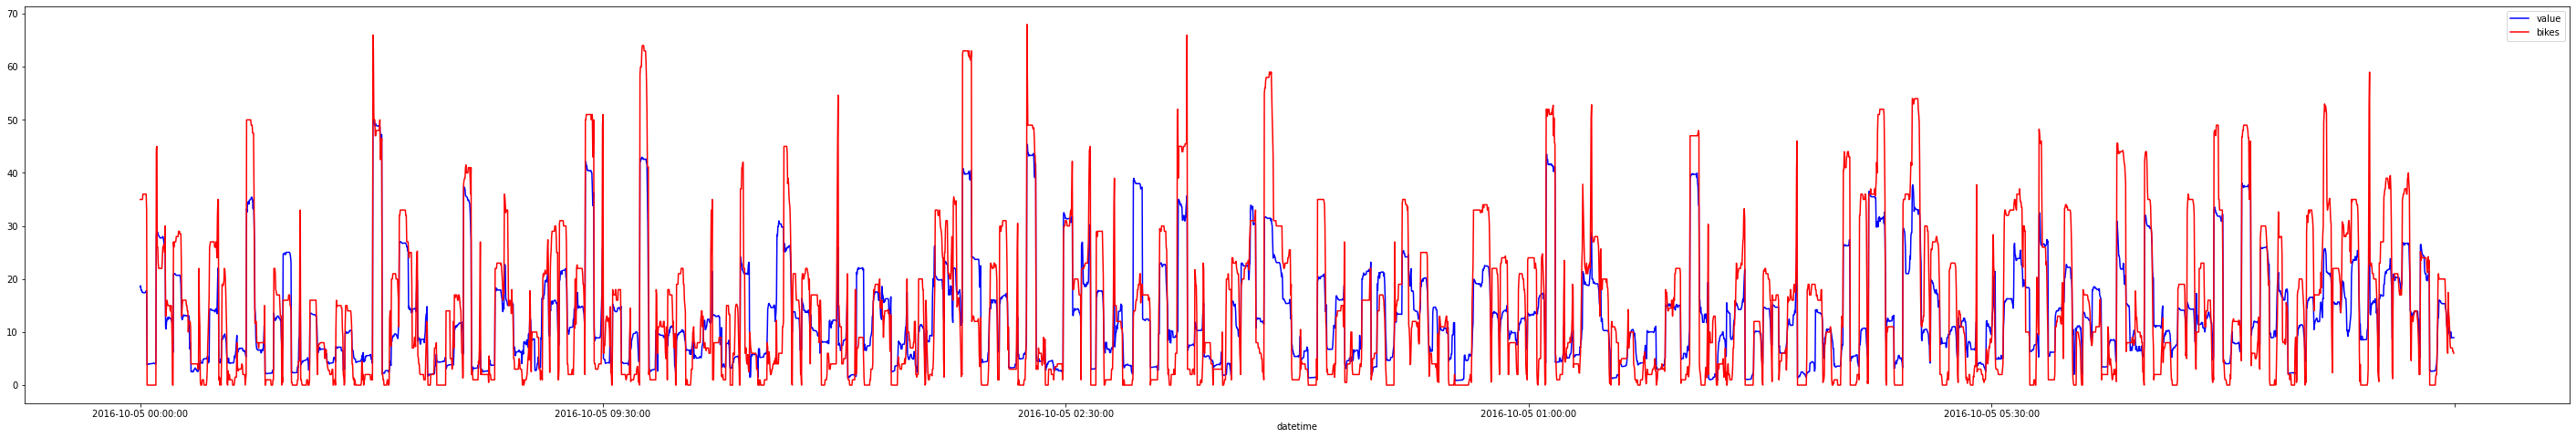

In [12]:
ax = test['value'][:5000].plot(figsize=(50,8), legend=True, color='blue')
test['bikes'][:5000].plot(legend=True, color='red', figsize=(50,8))

In [13]:
from statsmodels.tools.eval_measures import meanabs
error=meanabs(test['value'], test['bikes'])
error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


6.293905947856586

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(( y_true.mean() - y_pred.mean() ) / y_true.mean() )) * 100
mean_absolute_percentage_error(np.array(test['bikes']) , np.array( test['value'])) 



8.33830612986489

In [15]:
MAPE=mean_absolute_percentage_error(np.array(test['bikes'][:5000]) , np.array( test['value'][:5000]))
print('MAPE error sur 5000 valeurs est :',MAPE)

error=meanabs(test['value'][:5000], test['bikes'][:5000])
print('MAE error sur 5000 valeurs est :',error)


MAPE error sur 5000 valeurs est : 11.476953681796234
MAE error sur 5000 valeurs est : 6.3459132733811785
